[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/017_clasificacion_multiclase/clasificacion_multiclase.ipynb)

# Clasificación Multiclase

La arquitectura de `Perceptrón` que hemos visto hasta ahora nos ha permitido llevar a cabo dos tipos de tareas: regresión lineal y clasificación binaria. En este post vamos a mejorar la implementación de nuestro modelo para ser capaces de utilizarlo en la tarea de clasificación en varias clases. En primer lugar, vamos a revisar la arquitectura del `Perceptrón`. Hasta ahora, nuestro modelo era capaz de recibir una serie de entradas y dar como resultado una única salida.

![](https://www.researchgate.net/profile/Shibani_Singh2/publication/321141639/figure/fig2/AS:572731935727616@1513561342872/Schematic-of-Rosenblatts-perceptron.png)

La idea es la siguiente: si un `Perceptrón` es capaz de clasificación binaria (identificar una clase en particular de entre el resto), podemos utilizar tantos perceptrones como clases tengamos. En esta configuración, cada `Perceptrón` tendrá el objetivo de identificar una de las clases en particular del resto.

![](https://camo.githubusercontent.com/bcb4c2d2684739dd367e6e61d96102bb8ba28cd8/68747470733a2f2f6a6c6565776562626c6f672e66696c65732e776f726470726573732e636f6d2f323031372f30332f736f666d61782d72656772657373696f6e2e6a70673f773d36333326683d353237)

En esta nueva implementación, tendremos tantas salidas como clases (podemos usarlo también para regresión, cada salida correspondería a cada una de las magnitudes de interés). Calculamos la salida del modelo de la misma manera que en el caso del `Perceptrón` de una sola salida. La diferencia es que en la última capa aplicaremos una función de activación de tipo `softmax`. Esto nos dará como resultado una distribución de probabilidad sobre todas las clases. Finalmente, asignaremos aquella clase que tenga la probabilidad más alta.

$$ \hat{y} = \underset{k}{\arg\max} \ \ \sigma(\mathbf{w} \cdot \mathbf{x})_k $$

En el caso del `Perceptrón` con una sola salida, nuestros pesos estaban representados por un vector de longitud igual al número de entradas (más uno si tenemos en cuenta el *bias*). Ahora, al tener varias salidas, los pesos estarán representados por una matriz (puedes ver el vector anterior como una matriz de una sola columna). Este modelo también se conoce por el nombre de `Softmax Regression`.

> 💡 Puedes aprender sobre la función `softmax` en nuestro post sobre [probabilidad](https://sensioai.com/blog/010_probabilidad).

In [1]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

## Función de Pérdida

Para entrenar el modelo con el algoritmo de `descenso por gradiente` necesitamos una función de pérdida, una medida del error que nos sirva para optimizar los pesos. En este caso utilizamos la función de pérdida conocida como `Cross Entropy`.

$$ J(\mathbf{w}) = - \frac{1}{N} \sum^N_{j=1} \sum^K_{k=1} y_k^{(j)} log(\hat{y}_k^{(j)}) $$

donde $y_k^{(j)}$ es la probabilidad de que el elemento $j$ pertenezca a la clase $k$ (normalmente 1 ó 0). Cómo puedes ver, en el caso en el que tengamos sólo dos clases esta expresión es equivalente a la función de pérdida que utilizamos para clasificación binaria en el modelo de regresión logística (que puedes ver en este [post](https://sensioai.com/blog/015_logistic_regression)), la función `Binary Cross Entropy`.

Como siempre, para poder aplicar el algoritmo, no sólo necesitamos la función de pérdida sino también su derivada con respecto a los pesos del modelo que queremos optimizar. Calculando la derivada de la función anterior obtenemos la siguiente expresión.

$$ \frac{\partial J_k}{\partial \mathbf{w}} =  \frac{1}{N} \sum^{N}_{j=1} (\hat{y}_k^{(j)} - y_k^{(j)}) \mathbf{x}^{(j)} $$

Por motivos de estabilidad numérica, es común combinar la función `softmax` con la función `cross entropy` de la siguiente manera.

In [2]:
# aplica softmax + cross entropy de manera estable

def crossentropy(output, target):
    logits = output[np.arange(len(output)),target]
    entropy = - logits + np.log(np.sum(np.exp(output),axis=-1))
    return entropy

def grad_crossentropy(output, target):
    answers = np.zeros_like(output)
    answers[np.arange(len(output)),target] = 1    
    return (- answers + softmax(output)) / output.shape[0]

## Implementación

Vamos a mejorar ahora nuestra implementación del `Perceptrón` para ser capaz de llevar a cabo la tarea de clasificación multiclase (además de todas las que ya es capaz de hacer).

In [3]:
class Perceptron():
  def __init__(self, inputs, outputs):
    self.w = np.random.normal(loc=0.0, 
          scale = np.sqrt(2/(inputs+outputs)), 
          size = (inputs, outputs)) 
    self.ws = []
    self.loss = crossentropy
    self.grad_loss = grad_crossentropy
    
  def __call__(self, w, x):
    return np.dot(x, w) 

  def fit(self, x, y, epochs, lr, verbose=True, log_each=1):
    x = np.c_[np.ones(len(x)), x]
    for epoch in range(1,epochs+1):
        # Batch Gradient Descent
        y_hat = self(self.w, x)  
        # función de pérdida
        l = self.loss(y_hat, y).mean()
        # derivadas
        dldh = self.grad_loss(y_hat, y)
        dhdw = x
        dldw = np.dot(dhdw.T, dldh)
        # actualizar pesos
        self.w = self.w - lr*dldw
        # guardar pesos para animación
        self.ws.append(self.w.copy())
        # print loss
        if verbose and not epoch % log_each:
            print(f"Epoch {epoch}/{epochs} Loss {l}")
            
  def predict(self, x):
    x = np.c_[np.ones(len(x)), x]
    return self(self.w, x)

## El dataset Iris

Ahora vamos a probar nuestro nuevo modelo para clasificación multiclase con el dataset Iris, un dataset que ya hemos utilizado en varios posts anteriores para clasificar flores.

In [4]:
from sklearn.datasets import load_iris
import numpy as np

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_norm = (X - X_mean) / X_std

y = iris.target

X.shape, y.shape

((150, 2), (150,))

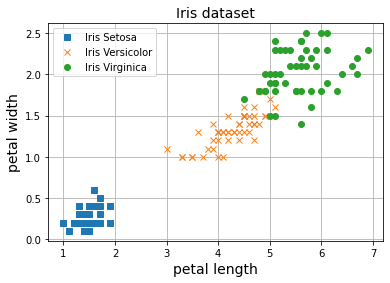

In [5]:
import matplotlib.pyplot as plt

plt.plot(X[y==0, 0], X[y==0, 1], 's', label="Iris Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], 'x', label="Iris Versicolor")
plt.plot(X[y==2, 0], X[y==2, 1], 'o', label="Iris Virginica")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

A diferencia de los posts anteriores en los que intentábamos separar una de las tres clases del resto, ahora vamos a intentar ser capaces de clasificar las tres clases a la vez.

In [6]:
np.random.seed(42)

perceptron = Perceptron(3, 3)
epochs, lr = 50, 1
perceptron.fit(X_norm, y, epochs, lr, log_each=10)

Epoch 10/50 Loss 0.3992838232798919
Epoch 20/50 Loss 0.290313203795845
Epoch 30/50 Loss 0.23774032243503038
Epoch 40/50 Loss 0.20631770086056744
Epoch 50/50 Loss 0.18530798162642056


In [7]:
from matplotlib.colors import ListedColormap
from matplotlib import animation, rc
rc('animation', html='html5')       
    
def animate(i, resolution=0.02):
    ax.clear()
    tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    X_new = (np.array([xx1.ravel(), xx2.ravel()]).T - X_mean)/X_std
    X_new = np.c_[np.ones(len(X_new)), X_new]
    w = perceptron.ws[i]
    Z = perceptron(w, X_new)
    Z = np.argmax(softmax(Z), axis=1) 
    #print(Z)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    ax.set_xlabel('petal length', fontsize=14)
    ax.set_ylabel('petal width', fontsize=14)
    classes = ["Iris-Setosa", "Iris-Versicolor", "Iris-Virginica"]
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=classes[cl], 
                    edgecolor='black')
    ax.legend(loc='upper left', fontsize=14)
    return [tit]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
anim = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
plt.close()
anim

Como puedes ver ahora nuestro modelo es capaz de separar todo el espacio de longitud y ancho del pétalo de una flor en tres clases. Dada una nueva flor, podemos saber su clase de la siguiente forma

In [8]:
# nuevo punto
X_new = [[2, 0.5]]
# normalizamos
X_new_norm = (X_new - X_mean) / X_std 
# salida del perceptron
y = perceptron.predict(X_new_norm)
y

array([[ 3.18405391,  1.31789892, -5.5272039 ]])

A la salida del perceptrón aplicamos la función `softmax` para convertirla en una distribución de probabilidad.

In [9]:
y_probas = softmax(y)
y_probas

array([[8.65889231e-01, 1.33968139e-01, 1.42630085e-04]])

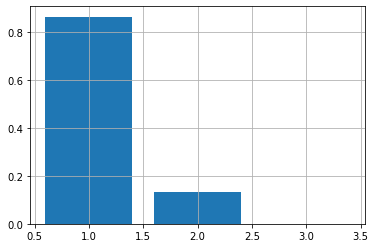

In [10]:
plt.bar(list(range(1,4)), y_probas[0])
plt.grid(True)
plt.show()

En una distribución de probabilidad, la suma de todas las probabilidad asignadas a cada una de las clases tiene que sumar 1.

In [11]:
y_probas.sum(axis=1)

array([1.])

Ahora asignaremos aquella clase con la mayor probabilidad.

In [12]:
y_pred = np.argmax(y_probas, axis=1)
y_pred

array([0], dtype=int64)

Si abstraemos la lógica en una función podemos probar varios puntos.

In [13]:
def evaluate(x):
    x = (x - X_mean) / X_std 
    y = perceptron.predict(x)
    y_probas = softmax(y)
    return np.argmax(y_probas, axis=1)

In [14]:
X = [[5, 1],[2, 0.5],[7, 3]]
evaluate(X)

array([1, 0, 2], dtype=int64)

## El dataset MNIST

Vamos a probar ahora nuestra nueva implementación para clasificar dígitos manuscritos con el dataset MNIST.

In [15]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

X.shape, y.shape

((70000, 784), (70000,))

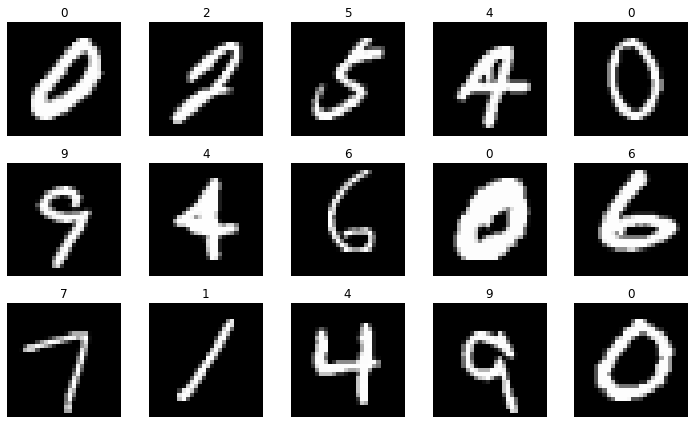

In [16]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        img = X[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(y[ix])
plt.tight_layout()
plt.show()

In [17]:
# normalizamos los datos

X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000].astype(np.int), y[60000:].astype(np.int)

In [18]:
# entranamos un perceptron para clasificación en 10 clases a partir de los pixeles de cada imágen

perceptron = Perceptron(785, 10)
epochs, lr = 200, 1
perceptron.fit(X_train, y_train, epochs, lr, log_each=10)

Epoch 10/200 Loss 1.0272297445490006
Epoch 20/200 Loss 0.5980381289205666
Epoch 30/200 Loss 0.4773168861894828
Epoch 40/200 Loss 0.41199523487346523
Epoch 50/200 Loss 0.39122900076745026
Epoch 60/200 Loss 0.3784132707330115
Epoch 70/200 Loss 0.3684527393218287
Epoch 80/200 Loss 0.36031727940205316
Epoch 90/200 Loss 0.35349819645727165
Epoch 100/200 Loss 0.3476707929601525
Epoch 110/200 Loss 0.34261370339472846
Epoch 120/200 Loss 0.33816962232121106
Epoch 130/200 Loss 0.33422308575592685
Epoch 140/200 Loss 0.33068707851031404
Epoch 150/200 Loss 0.32749456770253627
Epoch 160/200 Loss 0.32459294088243423
Epoch 170/200 Loss 0.32194023405806593
Epoch 180/200 Loss 0.3195025036891174
Epoch 190/200 Loss 0.3172519526894042
Epoch 200/200 Loss 0.31516556673743784


Calcularemos la precisión de nuestro modelo en los datos de test. Puedes aprender sobre ésta y otras métricas en este [post](https://sensioai.com/blog/016_metricas_clasficiacion).

In [19]:
def evaluate(x):
    y = perceptron.predict(x)
    y_probas = softmax(y)
    return np.argmax(y_probas, axis=1)

In [20]:
from sklearn.metrics import accuracy_score

y_pred = evaluate(X_test)
accuracy_score(y_test, y_pred)

0.9159

Con una precisión cercana al $91 \%$, vamos a visualizar algunas de las predicciones.

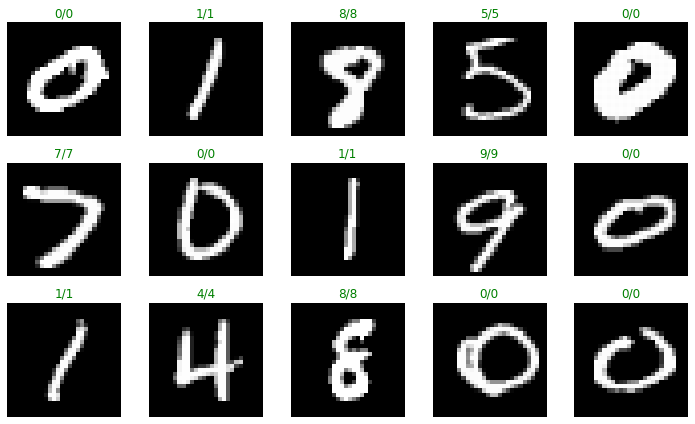

In [21]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
test_imgs, test_labs = [], []
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_test)-1)
        img = X_test[ix]
        y_pred = evaluate([img])[0]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(f"{y_test[ix]}/{y_pred}", color="green" if y_test[ix] == y_pred else "red")
plt.tight_layout()
plt.show()

¡ Nuestro modelo es bastante bueno reconociendo dígitos manuscritos ! Con la matriz de confusión podemos evaluar los puntos fuertes y débiles de nuestro modelo para poder mejorarlo.

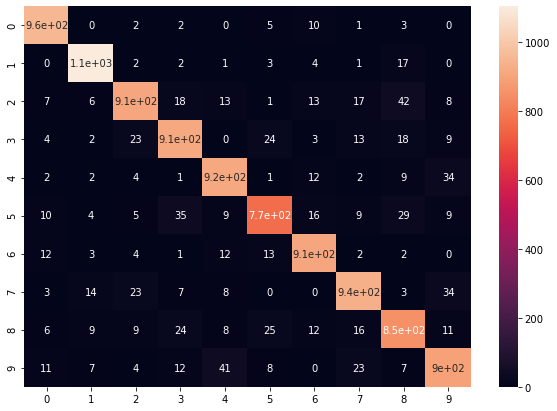

In [22]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

y_pred = evaluate(X_test)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in range(0,10)], columns = [i for i in range(0,10)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

## Resumen

En este post hemos visto cómo mejorar nuestro `Perceptrón` para llevar a cabo la tarea de clasificación en varias clases, mientras que hasta ahora sólo habíamos sido capaces de clasificación binaria (en dos clases). Para ello, en primer lugar hemos replicado la arquitectura tantas veces como clases tenemos, teniendo una salida del modelo para cada clase. Usando la función `softmax` como función de activación podemos convertir esta salida en una distribución de probabilidad, que usamos para escoger la clase final (aquella con mayor probabilidad). Para entrenar el modelo con el algoritmo de descenso por gradiente utilizamos la función de pérdida `cross entropy`, cuya formulación y derivadas hemos calculado. Tras la implementación de estos cambios hemos utilizado nuestro modelo para clasificación multiclase con los datasets Iris y MNIST, consiguiendo una buena precisión.